# Section 6b: Correlation of Job States

In [1]:
import pyspark.sql.functions as F
from util.read_and_print_df import *
from util.handle_nan import *
from util.extract_json_attributes import *
from util.plotting import *
import psutil
import matplotlib.pyplot as plt
import builtins
import numpy as np
import seaborn as sns

In [3]:
spark = get_spark_session()

Assigning 541 GB of memory per spark driver and executor, and use 126 cores.


In [4]:
df_prom_slurm = spark.read.parquet(path_job_node_joined_dataset)
df_prom_slurm = df_prom_slurm.withColumn("job_duration_seconds", F.unix_timestamp('end_date') - F.unix_timestamp('start_date'))
df_prom_slurm.show(5, False)

24/05/03 22:35:28 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+-------------------+------+-----------------+-----------+----------------+---+------------------------+-----------------------+---------------------------+----------+----------+------------------------+----------------------------+-------------------------+-----------------------+-----------------+------------------------+----------------------------+---------------+-----------------------+------------------------+----------------------+-----------------------------+--------------------------+------------------+-------------------------+-------------------------+------------------+----------------+---------------------------+----------------------------+---------------------------+-------------------------------+-------------------------+-------------------------------------+--------------------------------+---------------------------------+------------------------------+--------------------------+---------------------------+--------------------------+------------------------

In [5]:
k = 1

df_prom_slurm_concurrent = df_prom_slurm.join(
    df_prom_slurm.groupBy('node', 'timestamp').agg(F.count(F.lit(1)).alias('concurrent_job_count')), ['node', 'timestamp'], how='left'
)


# generic nodes
df_prom_slurm_generic = df_prom_slurm_concurrent.filter(col('gpu_node') == 0)
df_prom_slurm_generic_node_grouped = df_prom_slurm_generic.groupBy('node').agg(F.mean('node_power_usage').alias('node_power_usage_mean'), F.stddev('node_power_usage').alias('node_power_usage_std'))
df_prom_slurm_generic_high_load_nodes = df_prom_slurm_generic.join(df_prom_slurm_generic_node_grouped, 'node', 'left').filter(col('node_power_usage') > col('node_power_usage_mean') + k * col('node_power_usage_std'))
df_prom_slurm_generic_high_load_nodes_jobs_concurrent = df_prom_slurm_generic_high_load_nodes.filter(col('concurrent_job_count') > 1)

df_prom_slurm_generic_high_load_jobs_concurrent = df_prom_slurm_generic_high_load_nodes_jobs_concurrent.groupBy('slurm_id', 'node', 'timestamp').agg(
    F.first('state').alias('state'),
)

df_prom_slurm_generic_high_load_jobs_concurrent_2 = df_prom_slurm_generic_high_load_jobs_concurrent
for c in df_prom_slurm_generic_high_load_jobs_concurrent.columns:
    df_prom_slurm_generic_high_load_jobs_concurrent_2 = df_prom_slurm_generic_high_load_jobs_concurrent_2.withColumnRenamed(c, f'{c}_2')

df_prom_slurm_generic_high_load_jobs_concurrent_other_jobs = df_prom_slurm_generic_high_load_jobs_concurrent.join(df_prom_slurm_generic_high_load_jobs_concurrent_2,
    (df_prom_slurm_generic_high_load_jobs_concurrent['node'] == df_prom_slurm_generic_high_load_jobs_concurrent_2['node_2']) &
    (df_prom_slurm_generic_high_load_jobs_concurrent['timestamp'] == df_prom_slurm_generic_high_load_jobs_concurrent_2['timestamp_2']) &
    (df_prom_slurm_generic_high_load_jobs_concurrent['slurm_id'] != df_prom_slurm_generic_high_load_jobs_concurrent_2['slurm_id_2'])
    , how='inner').drop('node_2', 'timestamp_2')

df_prom_slurm_generic_high_load_jobs_concurrent_other_jobs.show(5, False)
print(df_prom_slurm_generic_high_load_jobs_concurrent_other_jobs.count())


# ml nodes
df_prom_slurm_ml = df_prom_slurm_concurrent.filter(col('gpu_node') == 1)
df_prom_slurm_ml_node_grouped = df_prom_slurm_ml.groupBy('node').agg(F.mean('node_power_usage').alias('node_power_usage_mean'), F.stddev('node_power_usage').alias('node_power_usage_std'))
df_prom_slurm_ml_high_load_nodes = df_prom_slurm_ml.join(df_prom_slurm_ml_node_grouped, 'node', 'left').filter(col('node_power_usage') > col('node_power_usage_mean') + k * col('node_power_usage_std'))
df_prom_slurm_ml_high_load_nodes_jobs_concurrent = df_prom_slurm_ml_high_load_nodes.filter(col('concurrent_job_count') > 1)

df_prom_slurm_ml_high_load_jobs_concurrent = df_prom_slurm_ml_high_load_nodes_jobs_concurrent.groupBy('slurm_id', 'node', 'timestamp').agg(
    F.first('state').alias('state'),
)

df_prom_slurm_ml_high_load_jobs_concurrent_2 = df_prom_slurm_ml_high_load_jobs_concurrent
for c in df_prom_slurm_ml_high_load_jobs_concurrent.columns:
    df_prom_slurm_ml_high_load_jobs_concurrent_2 = df_prom_slurm_ml_high_load_jobs_concurrent_2.withColumnRenamed(c, f'{c}_2')

df_prom_slurm_ml_high_load_jobs_concurrent_other_jobs = df_prom_slurm_ml_high_load_jobs_concurrent.join(df_prom_slurm_ml_high_load_jobs_concurrent_2,
    (df_prom_slurm_ml_high_load_jobs_concurrent['node'] == df_prom_slurm_ml_high_load_jobs_concurrent_2['node_2']) &
    (df_prom_slurm_ml_high_load_jobs_concurrent['timestamp'] == df_prom_slurm_ml_high_load_jobs_concurrent_2['timestamp_2']) &
    (df_prom_slurm_ml_high_load_jobs_concurrent['slurm_id'] != df_prom_slurm_ml_high_load_jobs_concurrent_2['slurm_id_2'])
    , how='inner').drop('node_2', 'timestamp_2')

df_prom_slurm_ml_high_load_jobs_concurrent_other_jobs.show(5, False)
print(df_prom_slurm_ml_high_load_jobs_concurrent_other_jobs.count())

+--------+-----+-------------------+---------+----------+---------+
|slurm_id|node |timestamp          |state    |slurm_id_2|state_2  |
+--------+-----+-------------------+---------+----------+---------+
|1877186 |r10n1|2022-08-19 13:05:30|COMPLETED|1877216   |COMPLETED|
|1877186 |r10n1|2022-08-19 13:05:30|COMPLETED|1877217   |COMPLETED|
|1877186 |r10n1|2022-08-19 13:05:30|COMPLETED|1877239   |COMPLETED|
|1877186 |r10n1|2022-08-19 13:05:30|COMPLETED|1877240   |COMPLETED|
|1877216 |r10n1|2022-08-19 13:05:30|COMPLETED|1877186   |COMPLETED|
+--------+-----+-------------------+---------+----------+---------+
only showing top 5 rows



1181324


+--------+-----+-------------------+---------+----------+---------+
|slurm_id|node |timestamp          |state    |slurm_id_2|state_2  |
+--------+-----+-------------------+---------+----------+---------+
|1921574 |r28n1|2022-08-27 19:03:30|COMPLETED|1921575   |COMPLETED|
|1921574 |r28n1|2022-08-27 19:03:30|COMPLETED|1921576   |COMPLETED|
|1921574 |r28n1|2022-08-27 19:03:30|COMPLETED|1922426   |TIMEOUT  |
|1921575 |r28n1|2022-08-27 19:03:30|COMPLETED|1921574   |COMPLETED|
|1921575 |r28n1|2022-08-27 19:03:30|COMPLETED|1921576   |COMPLETED|
+--------+-----+-------------------+---------+----------+---------+
only showing top 5 rows



6673014


In [6]:
states = df_prom_slurm_generic_high_load_jobs_concurrent_other_jobs.select('state').distinct().rdd.map(lambda r: r[0]).collect()
print(states)

# group by job id and count for each job state how many concurrent jobs are there for each state
df_prom_slurm_generic_high_load_jobs_concurrent_other_jobs_grp = df_prom_slurm_generic_high_load_jobs_concurrent_other_jobs.groupBy('slurm_id', 'node', 'timestamp').agg(
    F.first(col('state')).alias('state'),
    *[F.sum(when(F.col('state_2') == state, 1).otherwise(0)).alias(f'{state}_other_jobs') for state in states]
)

# one-hot-encoding of states
for state in states:
    df_prom_slurm_generic_high_load_jobs_concurrent_other_jobs_grp = df_prom_slurm_generic_high_load_jobs_concurrent_other_jobs_grp.withColumn(f'{state}', when(col('state') == state, 1).otherwise(0))

# order cols
df_prom_slurm_generic_high_load_jobs_concurrent_other_jobs_grp = df_prom_slurm_generic_high_load_jobs_concurrent_other_jobs_grp.select(['slurm_id', 'node', 'timestamp'] + states + [f'{state}_other_jobs' for state in states])
df_prom_slurm_generic_high_load_jobs_concurrent_other_jobs_grp.show(5, False)



df_prom_slurm_ml_high_load_jobs_concurrent_other_jobs_grp = df_prom_slurm_ml_high_load_jobs_concurrent_other_jobs.groupBy('slurm_id', 'node', 'timestamp').agg(
    F.first(col('state')).alias('state'),
    *[F.sum(when(F.col('state_2') == state, 1).otherwise(0)).alias(f'{state}_other_jobs') for state in states]
)

for state in states:
    df_prom_slurm_ml_high_load_jobs_concurrent_other_jobs_grp = df_prom_slurm_ml_high_load_jobs_concurrent_other_jobs_grp.withColumn(f'{state}', when(col('state') == state, 1).otherwise(0))

df_prom_slurm_ml_high_load_jobs_concurrent_other_jobs_grp = df_prom_slurm_ml_high_load_jobs_concurrent_other_jobs_grp.select(['slurm_id', 'node', 'timestamp'] + states + [f'{state}_other_jobs' for state in states])
df_prom_slurm_ml_high_load_jobs_concurrent_other_jobs_grp.show(5, False)

['OUT_OF_MEMORY', 'TIMEOUT', 'FAILED', 'CANCELLED', 'NODE_FAIL', 'COMPLETED']


+--------+------+-------------------+-------------+-------+------+---------+---------+---------+------------------------+------------------+-----------------+--------------------+--------------------+--------------------+
|slurm_id|node  |timestamp          |OUT_OF_MEMORY|TIMEOUT|FAILED|CANCELLED|NODE_FAIL|COMPLETED|OUT_OF_MEMORY_other_jobs|TIMEOUT_other_jobs|FAILED_other_jobs|CANCELLED_other_jobs|NODE_FAIL_other_jobs|COMPLETED_other_jobs|
+--------+------+-------------------+-------------+-------+------+---------+---------+---------+------------------------+------------------+-----------------+--------------------+--------------------+--------------------+
|1524560 |r10n13|2022-06-30 20:23:00|0            |0      |1     |0        |0        |0        |0                       |0                 |2                |0                   |0                   |0                   |
|1524560 |r10n13|2022-06-30 20:24:00|0            |0      |1     |0        |0        |0        |0               

+--------+-----+-------------------+-------------+-------+------+---------+---------+---------+------------------------+------------------+-----------------+--------------------+--------------------+--------------------+
|slurm_id|node |timestamp          |OUT_OF_MEMORY|TIMEOUT|FAILED|CANCELLED|NODE_FAIL|COMPLETED|OUT_OF_MEMORY_other_jobs|TIMEOUT_other_jobs|FAILED_other_jobs|CANCELLED_other_jobs|NODE_FAIL_other_jobs|COMPLETED_other_jobs|
+--------+-----+-------------------+-------------+-------+------+---------+---------+---------+------------------------+------------------+-----------------+--------------------+--------------------+--------------------+
|1914287 |r32n4|2022-08-25 13:14:00|0            |0      |0     |0        |0        |1        |0                       |0                 |0                |0                   |0                   |3                   |
|1914287 |r32n4|2022-08-25 13:42:00|0            |0      |0     |0        |0        |1        |0                    

In [7]:
df_slurm_generic_high_load_nodes = df_prom_slurm_generic_high_load_jobs_concurrent_other_jobs_grp.drop('slurm_id', 'node', 'timestamp').toPandas()
corr_generic_high_load_nodes = df_slurm_generic_high_load_nodes.corr()
subset_corr_matrix_generic_high_load_nodes = corr_generic_high_load_nodes.iloc[:6, -6:]
display(subset_corr_matrix_generic_high_load_nodes)

df_slurm_ml_high_load_nodes = df_prom_slurm_ml_high_load_jobs_concurrent_other_jobs_grp.drop('slurm_id', 'node', 'timestamp').toPandas()
corr_ml_high_load_nodes = df_slurm_ml_high_load_nodes.corr()
subset_corr_matrix_ml_high_load_nodes = corr_ml_high_load_nodes.iloc[:6, -6:]
display(subset_corr_matrix_ml_high_load_nodes)

,OUT_OF_MEMORY_other_jobs,TIMEOUT_other_jobs,FAILED_other_jobs,CANCELLED_other_jobs,NODE_FAIL_other_jobs,COMPLETED_other_jobs
OUT_OF_MEMORY,0.568290,-0.062878,0.075389,-0.028503,-0.023956,0.068981
TIMEOUT,-0.131120,0.574788,-0.150103,-0.062727,-0.064942,-0.497956
FAILED,0.050320,-0.088392,0.736445,-0.007220,-0.030577,-0.160532
CANCELLED,-0.034007,-0.045888,-0.022586,0.863538,-0.015260,-0.138235
NODE_FAIL,-0.032773,-0.063449,-0.037846,-0.017692,0.808360,-0.123357
COMPLETED,-0.127700,-0.409743,-0.264995,-0.158326,-0.122296,0.566885


,OUT_OF_MEMORY_other_jobs,TIMEOUT_other_jobs,FAILED_other_jobs,CANCELLED_other_jobs,NODE_FAIL_other_jobs,COMPLETED_other_jobs
OUT_OF_MEMORY,0.001969,-0.017643,0.051423,-0.012955,-0.000899,0.001471
TIMEOUT,-0.022146,0.551838,-0.065853,-0.259702,-0.016081,-0.190088
FAILED,0.066783,-0.059753,0.342839,-0.043093,-0.004693,-0.035394
CANCELLED,-0.016630,-0.281583,-0.047514,0.731288,-0.017644,-0.430351
NODE_FAIL,-0.001031,-0.014436,-0.004887,-0.014347,0.120551,0.013011
COMPLETED,0.007517,-0.191718,-0.037750,-0.409290,0.025858,0.553668


In [8]:
def show_concurrent_job_corr_triangle(corr_matrix, title, cmap, filename):
    fig, ax = plt.subplots()

    # Create a mask to ignore the upper triangle of the matrix
    matrix = np.triu(corr_matrix, 1)

    sns.heatmap(corr_matrix, annot=True, fmt='.2f', mask=matrix, cmap=cmap, annot_kws={"size": 16}, square=True, ax=ax, vmin=-0.5, vmax=1.0, cbar_kws={'label': 'Correlation'})

    colorbar = ax.collections[0].colorbar
    color_ticks = np.round(np.linspace(-0.5, 1.0, 6),2)
    colorbar.set_ticks(color_ticks)

    plt.yticks(fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=16)

    tick_positions = [x+0.5 for x in range(6)]
    ax.xaxis.set_major_locator(ticker.FixedLocator(tick_positions))
    ax.set_xticklabels(corr_matrix.index, fontsize=16, horizontalalignment='right', rotation=45)
    #ax.set_title(title, fontsize=16)

    fig.savefig(f'{filename}.png', bbox_inches = 'tight', dpi=300)
    fig.savefig(f'{filename}.pdf', bbox_inches = 'tight')

    plt.show()

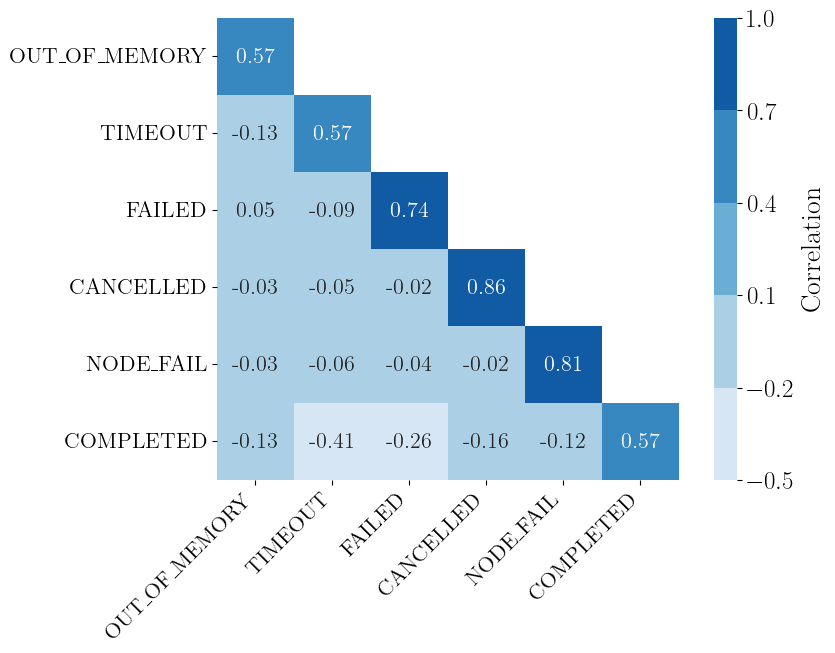

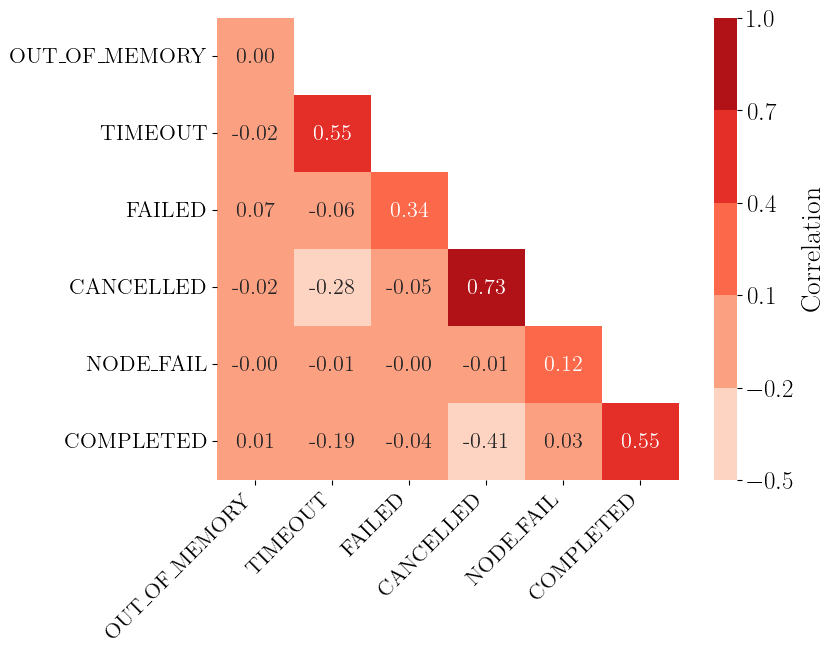

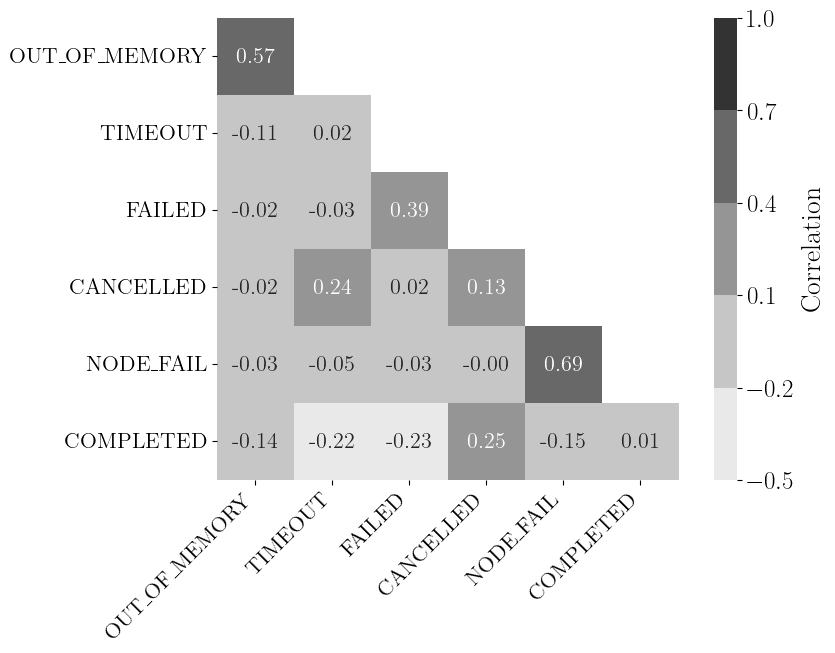

In [9]:
set_one_column_figure_font(height_multiplier=1.0)

show_concurrent_job_corr_triangle(subset_corr_matrix_generic_high_load_nodes, 'Generic High Load Nodes', sns.color_palette("Blues", 5).as_hex(), 'plots/section_6/fig-corr_heatmap_generic_high_load_nodes')
show_concurrent_job_corr_triangle(subset_corr_matrix_ml_high_load_nodes, 'ML High Load Nodes', sns.color_palette("Reds", 5).as_hex(), 'plots/section_6/fig-corr_heatmap_ml_high_load_nodes')
show_concurrent_job_corr_triangle(subset_corr_matrix_generic_high_load_nodes - subset_corr_matrix_ml_high_load_nodes, 'Difference High Load Nodes', sns.color_palette("Greys", 5).as_hex(), 'plots/section_6/fig-corr_heatmap_diff_high_load_nodes')